In [1]:
#Quantum Programming Homework 5: QCA on IonQ Hardware
#04/14/22
#Nathan Taylor

In [2]:
import cirq
import cirq.ionq as ionq
import matplotlib.pyplot as plt
import numpy as np
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

In [3]:
#Functions
#Efficient gate scheduling
def parallelCH(qubits):
    ops = []
    y1_mom = []
    y2_mom = []
    cx1_mom = []#CZ is not native in IONQ so we have to construct it from CNOT and Hadamards - which is lame
    cx2_mom = []
    y3_mom = []
    h1_mom = []
    h2_mom = []
    
    #even sites
    for i in range(len(qubits)):
        if i % 2 == 0:
            y1_mom.append(cirq.ry(np.pi/4)(qubits[i]))
            y2_mom.append(cirq.ry(-np.pi/4)(qubits[i]))
            if i < len(qubits) - 1:
                h1_mom.append(cirq.H(qubits[i+1]))
                cx1_mom.append(cirq.CX(qubits[i],qubits[i+1]))
        else:
            y2_mom.append(cirq.ry(np.pi/4)(qubits[i]))
            y3_mom.append(cirq.ry(-np.pi/4)(qubits[i]))
            if i < len(qubits) - 1:
                h2_mom.append(cirq.H(qubits[i+1]))
                cx2_mom.append(cirq.CX(qubits[i],qubits[i+1]))          
                
    ops.append(y1_mom)
    ops.append(h1_mom)
    ops.append(cirq.Moment(cx1_mom))
    ops.append(h1_mom)
    ops.append(h2_mom)
    ops.append(cirq.Moment(cx2_mom))
    ops.append(h2_mom)
    
    ops.append(y2_mom)
    
    ops.append(h1_mom)
    ops.append(cirq.Moment(cx1_mom))
    ops.append(h1_mom)
    ops.append(h2_mom)
    ops.append(cirq.Moment(cx2_mom))
    ops.append(h2_mom)
    ops.append(y3_mom)
    return ops

#c) Evolve and Measure
def simCircuit(oplist, counts):#Simulate the circuit
    sim = cirq.Simulator()
    circuit = cirq.Circuit(oplist)
    sample = sim.run(circuit, repetitions=counts)
    statelist = str(sample)[2:].split(", ")#list of states for each qubit
    
    #format output
    L = len(statelist)#number of qubits
    state_dictionary = {}
    for c in range(counts):
        nstate = ""
        for q in range(L):
            nstate += str(statelist[q][c])
        if nstate in state_dictionary:
            state_dictionary[nstate] += 1
        else:
            state_dictionary[nstate] = 1
    stateArray = np.zeros([0, 2])
    for key, value in state_dictionary.items():
        stateArray = np.append(stateArray, [np.array([key, str(value/counts)])], axis=0)
    
    return stateArray

def ZExpectation(data):
    L = len(data[0, 0])#number of qubits
    z_avg = np.zeros(L)#list of averages
    
    for row in data:
        for q in range(L):
            z_avg[q] += float(row[0][q]) * float(row[1])#multiply each qubit by the probability the state appeared
    return z_avg

#e) Post-Selection
def ZZEnergy(state):
    zzenergy = 0
    for i in range(len(state)-1):#qubit iterator dont go over the edge
        if state[i] == state[i+1]:#adjacent qubits are in the same state
            zzenergy += 1
        else:
            zzenergy += -1
    return zzenergy

def ZZPostSelection(data, initial_state):
    renormalization = 0
    selected_states = np.zeros([0, 2])
    vInitial = '0' + initial_state + '0'
    for row in data:
        vCurrent = '0' + row[0] + '0'
        if ZZEnergy(vInitial) == ZZEnergy(vCurrent):
            selected_states = np.append(selected_states, [row], axis=0)
            renormalization += float(row[1])

    #Renormalize the states
    for row in selected_states:
        row[1] = str(float(row[1])/renormalization)
    return selected_states

Simulations


Text(0, 0.5, 'Qubit')

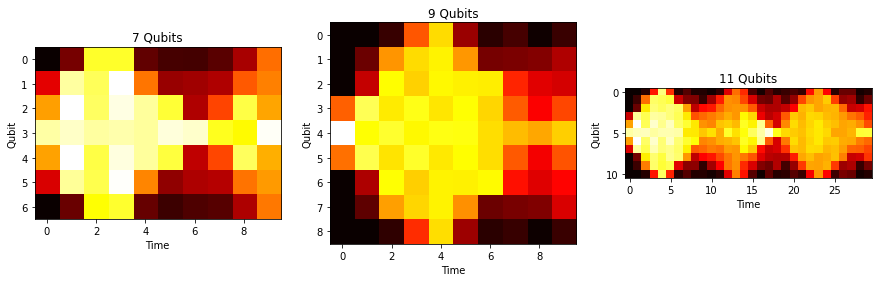

In [4]:
#a) Simulations
print("Simulations")
counts = 1000
fig, axes = plt.subplots(1,3,figsize=(15,15))

#7 qubits
L = 7
qubits = cirq.LineQubit.range(L)
initial_state = "0001000"
z7_matrix = np.zeros([0, L])

for t in range(1,11):
    pure_list = []
    pure_list.append(cirq.X(qubits[3]))
    for j in range(t):
        pure_list.append(parallelCH(qubits))
    pure_list.append(cirq.measure(*qubits, key='z'))
    pure_avg = ZExpectation(simCircuit(pure_list, counts))
    z7_matrix = np.append(z7_matrix, [pure_avg], axis=0)
heat7 = np.transpose(z7_matrix)

plt.subplot(1,3,1)
plt.imshow(heat7, cmap='hot')
plt.title("7 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

#9 qubits
L = 9
qubits = cirq.LineQubit.range(L)
initial_state = "000010000"
z9_matrix = np.zeros([0, L])

for t in range(1,11):
    pure_list = []
    pure_list.append(cirq.X(qubits[4]))
    for j in range(t):
        pure_list.append(parallelCH(qubits))
    pure_list.append(cirq.measure(*qubits, key='z'))
    pure_avg = ZExpectation(simCircuit(pure_list, counts))
    z9_matrix = np.append(z9_matrix, [pure_avg], axis=0)
heat9 = np.transpose(z9_matrix)

plt.subplot(1,3,2)
plt.imshow(heat9, cmap='hot')
plt.title("9 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

#11 qubits
L = 11
qubits = cirq.LineQubit.range(L)
initial_state = "00000100000"
z11_matrix = np.zeros([0, L])

for t in range(1,31):
    pure_list = []
    pure_list.append(cirq.X(qubits[5]))
    for j in range(t):
        pure_list.append(parallelCH(qubits))
    pure_list.append(cirq.measure(*qubits, key='z'))
    pure_avg = ZExpectation(simCircuit(pure_list, counts))
    z11_matrix = np.append(z11_matrix, [pure_avg], axis=0)
heat11 = np.transpose(z11_matrix)

plt.subplot(1,3,3)
plt.imshow(heat11, cmap='hot')
plt.title("11 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

In [5]:
#b) The Real Deal: Quantum Hardware (same thing)
#Add the circuit to the queue
def ionQueue(oplist, counts):
    service = ionq.Service()
    circuit = cirq.Circuit(oplist)
    job = service.create_job(circuit=circuit, repetitions=counts, target='qpu')
    return job.job_id()

#Have the circuits been run
def jobsCompleted(jlist):
    service = ionq.Service()
    for jid in jlist:
        monitor = service.get_job(jid)
        if monitor.status() != 'completed':
            return False
    return True

#Convert the direct data into something usable
def ParseData(result):
    #result is an nx2 matrix (each bit has a corresponding probabilty)
    rlist = str(result).split("\n")
    data = np.zeros([0,2])
    for r in rlist:
        dat = r.split(": ")
        data = np.append(data, [dat], axis=0)
    return data

In [6]:
#Add Jobs to the Queue - I need to stop running this code (I probably added about 120 extra jobs, oops)
#Run with stacked version to compare now
'''
counts = 1000
joblist = []

#7 qubits
L = 7
qubits = cirq.LineQubit.range(L)

for t in range(1,11):
    pure_list = []
    pure_list.append(cirq.X(qubits[3]))
    for j in range(t):
        pure_list.append(parallelCH(qubits))
    pure_list.append(cirq.measure(*qubits, key='z'))
    joblist.append(ionQueue(pure_list, counts))

#9 qubits
L = 9
qubits = cirq.LineQubit.range(L)

for t in range(1,11):
    pure_list = []
    pure_list.append(cirq.X(qubits[4]))
    for j in range(t):
        pure_list.append(parallelCH(qubits))
    pure_list.append(cirq.measure(*qubits, key='z'))
    joblist.append(ionQueue(pure_list, counts))
    
#11 qubits
L = 11
qubits = cirq.LineQubit.range(L)

for t in range(1,11):
    pure_list = []
    pure_list.append(cirq.X(qubits[5]))
    for j in range(t):
        pure_list.append(parallelCH(qubits))
    pure_list.append(cirq.measure(*qubits, key='z'))
    joblist.append(ionQueue(pure_list, counts))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-6-8370a5ea58b1>, line 41)

In [7]:
#Have the jobs been completed? Continue if this is true
joblist = ['8ff15675-f022-49b7-9c0e-9504253a172f','b75f3c0f-d272-42a4-a070-73cf9ac66407','183c7a25-cb4f-4537-9478-12bdba1aedb9','ae2464c9-bb50-4c93-b07f-3343d0c847c9','37d34109-d0d4-4797-82d7-4b2c94a6008f','c0914a4b-d41d-426f-85ba-e575b5771a46','5562e53e-1379-4a24-9eea-8f8167e1c442','08cf46c5-f5bc-4e52-bf56-c2e79fa54255','21e927f3-d524-4c5e-9654-ed3e409bfa0e','d60ce8f0-111a-4b19-9fd4-50e502e9a42c','15faa226-77c2-4318-ad74-0a1ec202605d','677dc4d9-7502-4dee-a46b-9adea51035f5','7341a803-a50d-406f-8f11-3299d9fd86f3','9e795f00-2f37-4e4b-bb6e-fd3c36234a4b','6f339bb0-f55e-44c7-a030-e23222e13883','38753742-33a7-4f73-aee6-b24b9ca22bc2','b62e1d02-27ba-4d71-9e38-beefdaff41ec','4dd86824-8f88-4e6a-a94f-aed218ec01ad','15a8ae94-b592-4c20-bd66-f56eb48856ff','e3fa6e35-6ff2-4ea7-9293-b4872808eda9','f4766546-1bde-42a4-bfa3-4531afb244ca','2c4add64-450b-41bf-823b-c47c5db89c17','5496cfc5-2755-4f48-8d15-333f13a0278b','6a4f04c4-11f3-4161-ad2a-cd549d4a5995','ed5b8f65-2253-40f5-8a56-13c2a461f9cb','dea5a4ba-a4bc-4a87-bc84-c48a0debb1fd','8367b1df-124a-43ce-8b12-100e1e4c3e22','084824c1-15c3-4d9c-b323-cbf6452f795a','b88a731c-febf-441f-bf7d-472913c4e7f4','61ac76f0-a5fe-446f-91d3-f1a992d87baf']
#joblist = ['b4604e50-f8b6-4ddc-8f08-1ed9b3fc8507', 'e428c28e-543c-4a7a-9e93-3c5610776499', 'd5ec5aed-305e-4e9d-aacb-41dc81804e74', '37dd4055-bc33-4648-bc47-6f1d3e6a1518', 'b755d91a-1aa8-4aae-a066-a6e7b4d79305', '1f1142a0-1156-49be-aee4-9bc83294b530', 'f166df98-1165-4da8-9957-a6a4b5ba31a6', '7b37fa95-8935-4b5c-ae67-c20894da8679', 'c2f0be77-978e-4e8e-983c-f8dcb1e7ed54', '4d97c491-a16f-420e-91fc-f514ef4990db', '4d632826-7bdc-4be3-954e-cf50058ddc39', '9b4e761a-435c-440d-abe0-8080d601d4f9', 'a2338ac5-4747-4b32-bfab-481a8b975361', '31f4a695-e518-44d1-b05c-a58ea1d4c34c', 'bb4d6a92-78f0-4a03-b455-887a1f2b9fcb', '9034b8a3-2b1c-46a4-b953-666da5a989bf', '68f93000-0bfc-45ba-89b8-14426d9e59de', '579191b0-8424-440f-9a77-2bd213890bd9', 'd23dded2-7f7e-48c8-a2c4-47753e2dfd1d', 'a923c190-e9f2-454b-98c6-6ee5e02b022e', '8330e684-d595-4370-a527-e3f283add169', '210093e0-d26b-476a-aa61-e487c5980943', 'cf07e501-74bb-4fae-b660-e4f6dbca5648', 'cd3e5cb8-1f03-4b9a-8c1e-7cac4b8d40ca', '871fe511-dc92-44a6-82b4-416c7e74f74f', 'ec1f0158-ded6-4c60-8f7a-8028a01c6615', 'f89dcf0f-46d2-433f-9c60-3792e67c8877', 'c69c3bdb-5c09-427c-9ac8-6a888df41c58', 'a38fd6ac-6b0d-41bf-9d04-bb54e1be8127', 'd6a2db11-ee2a-41b6-9dee-02c9e138d6e2']
print(jobsCompleted(joblist))

True


Hardware


Text(0, 0.5, 'Qubit')

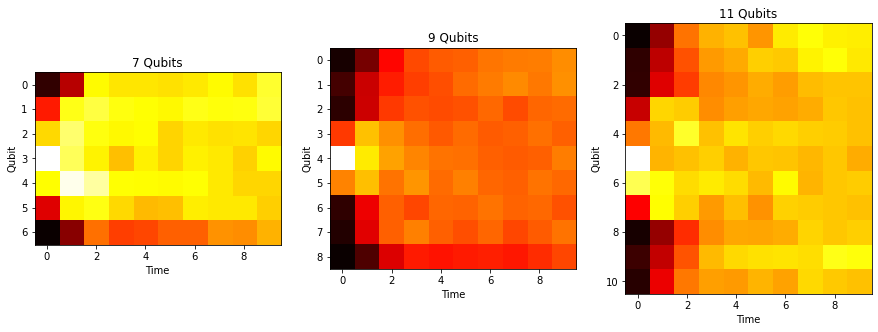

In [8]:
#Plot the Data
jindex = 0
z7_map = np.zeros([0, 7])
z9_map = np.zeros([0, 9])
z11_map = np.zeros([0, 11])

service = ionq.Service()
for jid in joblist:
    same_job = service.get_job(jid)
    result = same_job.results()
    q_avg = ZExpectation(ParseData(result))
    
    if jindex < 10:
        z7_map = np.append(z7_map, [q_avg], axis=0)
    elif jindex < 20:
        z9_map = np.append(z9_map, [q_avg], axis=0)
    else:
        z11_map = np.append(z11_map, [q_avg], axis=0)
    jindex += 1
    
print("Hardware")
fig, axes = plt.subplots(1,3,figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(np.transpose(z7_map), cmap='hot')
plt.title("7 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

plt.subplot(1,3,2)
plt.imshow(np.transpose(z9_map), cmap='hot')
plt.title("9 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

plt.subplot(1,3,3)
plt.imshow(np.transpose(z11_map), cmap='hot')
plt.title("11 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

This looks like hot trash. Quantum computers suck

Post-Selected Data


Text(0, 0.5, 'Qubit')

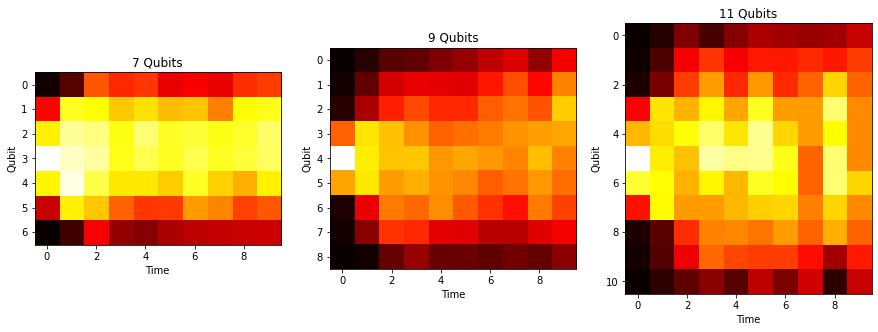

In [9]:
#c) Post-Selection
jindex = 0
z7_map = np.zeros([0, 7])
init7 = "0001000"
z9_map = np.zeros([0, 9])
init9 = "000010000"
z11_map = np.zeros([0, 11])
init11 = "00000100000"

service = ionq.Service()
for jid in joblist:
    same_job = service.get_job(jid)
    result = same_job.results()
    data = ParseData(result)
    
    if jindex < 10:
        selected_data = ZZPostSelection(data, init7)
        q_avg = ZExpectation(selected_data)
        z7_map = np.append(z7_map, [q_avg], axis=0)
    elif jindex < 20:
        selected_data = ZZPostSelection(data, init9)
        q_avg = ZExpectation(selected_data)
        z9_map = np.append(z9_map, [q_avg], axis=0)
    else:
        selected_data = ZZPostSelection(data, init11)
        q_avg = ZExpectation(selected_data)
        z11_map = np.append(z11_map, [q_avg], axis=0)
    jindex += 1
    
print("Post-Selected Data")
fig, axes = plt.subplots(1,3,figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(np.transpose(z7_map), cmap='hot')
plt.title("7 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

plt.subplot(1,3,2)
plt.imshow(np.transpose(z9_map), cmap='hot')
plt.title("9 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

plt.subplot(1,3,3)
plt.imshow(np.transpose(z11_map), cmap='hot')
plt.title("11 Qubits")
plt.xlabel("Time")
plt.ylabel("Qubit")

This is marginally better, but still bad. It's essentially the equivalent of a 6% pauli error rate for every 2 qubit gate. In the simulations of gate error, the reflection pattern still came out at 1% errors and got a little better with post-selection. Here there's nothing at all. Post-selection may have helped but there is so much diffusion that its hard to tell.